# Time series econometrics on crypto currency data

## Load data

I'll use Ethereum AUD as an example for now. See https://www.ethereum.org/ for more info.

"Unlike the Bitcoin blockchain which is essentially a list of the transactions on the network, the Ethereum blockchain contains both the list of transactions and the state of the blockchain (in the simplest case, the balances of all the accounts). The Ethereum whitepaper provides a list of potential use cases for the platform, but the primary one is the ability to build ‘smart contracts’ that will execute themselves, eliminating the need for counterparties to rely on each others trustworthiness.
...
There are two major differences between Ether and Bitcoin. First, unlike Bitcoin who’s total supply is capped at 21 million units, there is no fixed supply of Ether. Secondly, blocks are added to the Ether blockchain every 15 seconds (on average), unlike the approximately 10 minutes for Bitcoin." – See [this dude's thesis](https://yorkspace.library.yorku.ca/server/api/core/bitstreams/9be8e8b2-5247-42df-9e7b-eb58f02c633d/content).

In [123]:
#!pip install yfinance
import yfinance as yf
import datetime as dt
import pandas as pd

start = dt.datetime(2022,12,1)
end = dt.datetime(2023,12,2)

df = yf.download('ETH-AUD', start, end)

[*********************100%%**********************]  1 of 1 completed


In [124]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-01,1905.750366,1902.465576,1864.194458,1873.937744,1873.937744,10069424071
2022-12-02,1874.018066,1904.564819,1863.372070,1904.564819,1904.564819,9143367234
2022-12-03,1904.790161,1912.712524,1826.441895,1829.241577,1829.241577,8345758516
2022-12-04,1829.071289,1884.089722,1828.619019,1879.173462,1879.173462,7594637486
2022-12-05,1878.795044,1915.492432,1869.946289,1878.171631,1878.171631,9125425447


In [125]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-27,3166.480225,3181.549561,3097.235596,3135.169678,3135.169678,12239314271
2023-11-28,3133.809082,3147.625732,3009.053955,3065.574463,3065.574463,15989736738
2023-11-29,3065.725586,3118.075195,3017.007324,3079.087402,3079.087402,14890518016
2023-11-30,3078.860107,3125.369385,3057.944336,3067.608643,3067.608643,13517824040
2023-12-01,3066.746094,3109.025391,3053.591797,3106.890625,3106.890625,12272509114


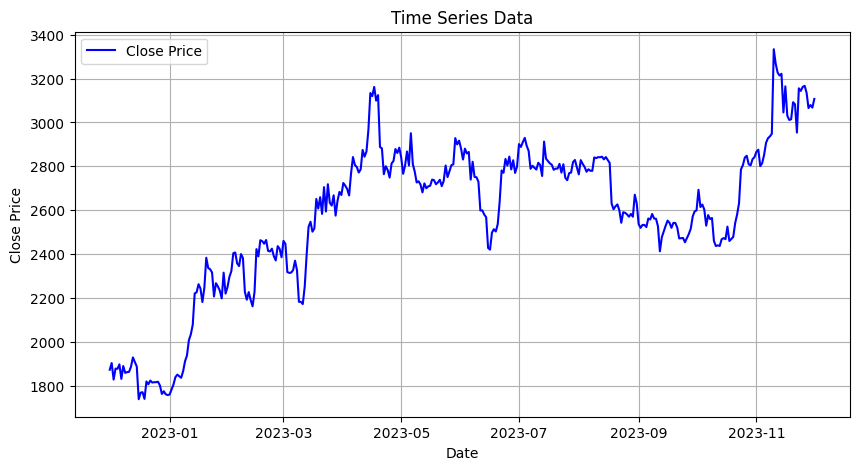

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Close'], linestyle='-', color='b', label='Close Price')
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

## Stationarity

We see ETH-AUD has a general upward trend over the year. 

To calculate reliable test statastics, we need stationarity in our data. Stationarity is a fundamental assumption in many time series models as it simplifies the modeling process and allows for the use of standard statistical techniques. When your data is stationary, you can make meaningful inferences about the relationships between variables and make reliable forecasts. Non-stationary data can make it challenging to estimate model parameters and can lead to unstable and unreliable results.

Stationarity is where a time series has a constant mean and constant variance over time. From a purely visual assessment, time plots that do not show trends or seasonality can be considered stationary.

### Transformations

We can transform the time series to be stationary by:
1. Taking the log;
2. Using the growth rate; or
3. Differencing over time (taking the log of today and minus it by the log of yesterday).

I'll start by taking the log:

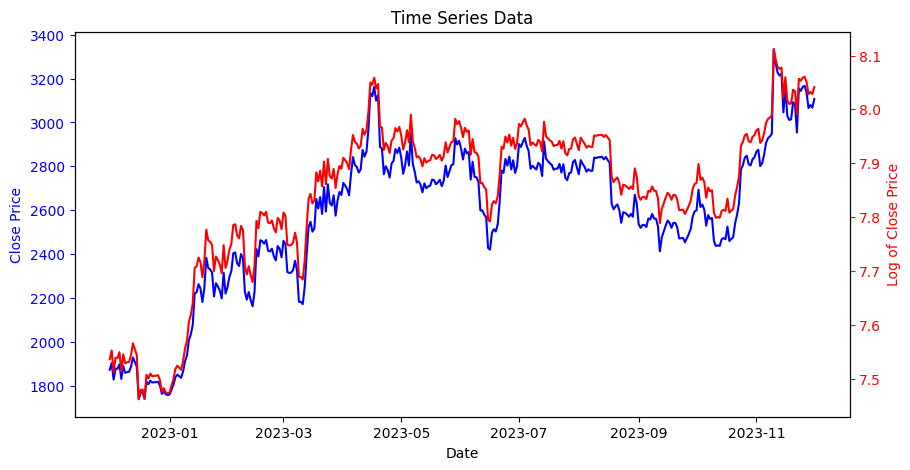

In [127]:
# Taking the log
import numpy as np

df['Log_Close'] = np.log(df['Close'])

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Close Price on the primary y-axis
ax1.plot(df.index, df['Close'], linestyle='-', color='b', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='b')
ax1.tick_params('y', colors='b')

# Create a secondary y-axis for Log of Close Price
ax2 = ax1.twinx()
ax2.plot(df.index, df['Log_Close'], linestyle='-', color='r', label='Log of Close Price')
ax2.set_ylabel('Log of Close Price', color='r')
ax2.tick_params('y', colors='r')

plt.title('Time Series Data')
plt.show()

Taking the log makes no difference (no pun intended).

Now I'll try the logged growth rate:

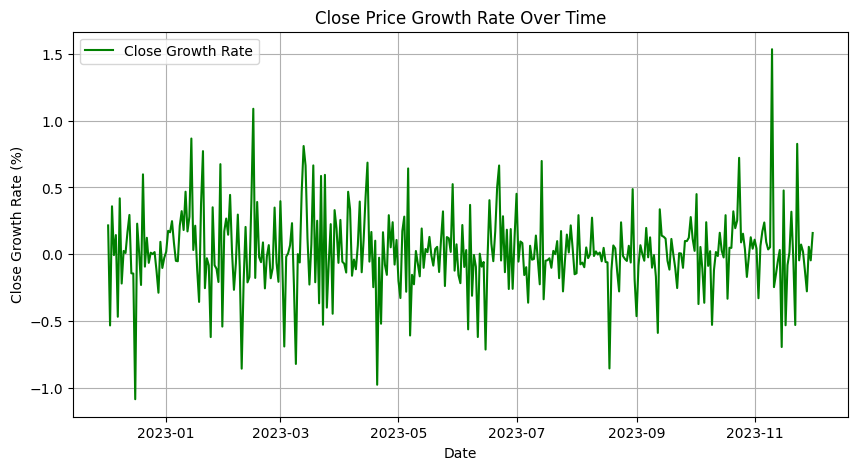

In [128]:
# Calculate the daily percentage change (growth rate)
df['Close_Log_Growth_Rate'] = df['Log_Close'].pct_change() * 100

# Plotting growth rate on its own
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Close_Log_Growth_Rate'], linestyle='-', color='g', label='Close Growth Rate')
plt.title('Close Price Growth Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Close Growth Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

That looks like a legit stationary process.

### Testing for stationarity

We can test for stationarity by:
1. plotting the Auto-Correlation Function, and Partial Auto-Correlation Function (ACF and PACF respectively); or
2. using the Augmented Dickey-Fuller (ADF) test.

We first plot the ACF and PACF:

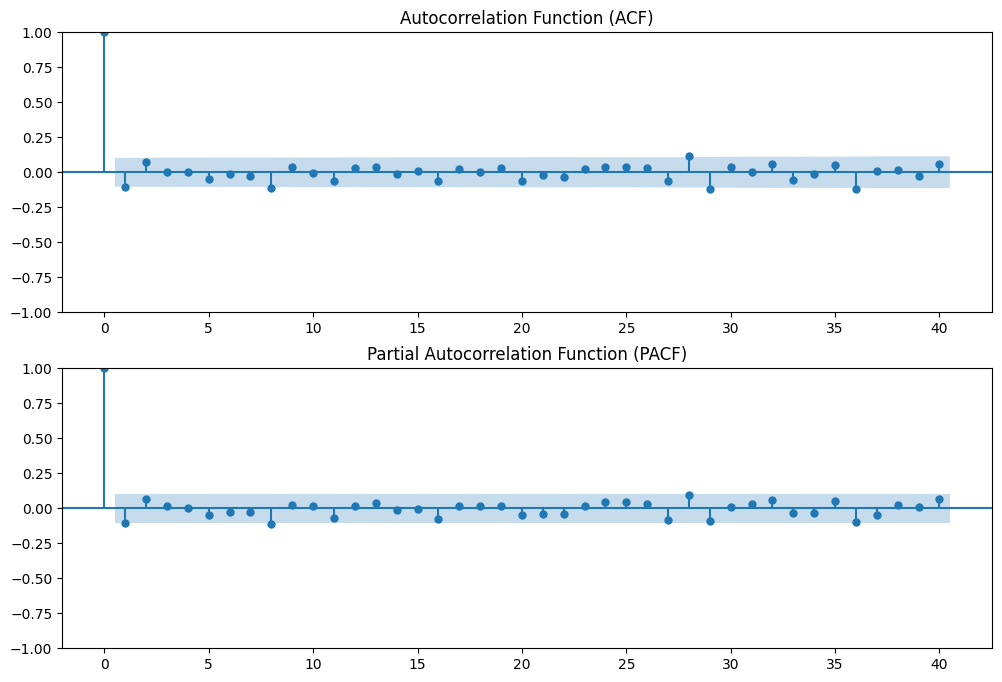

In [129]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

df = df.dropna()  # Drop the first row with NaN value

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot starting at lag 1
plot_acf(df['Close_Log_Growth_Rate'], lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot starting at lag 1
plot_pacf(df['Close_Log_Growth_Rate'], lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()


We find for ETH that there is significant autocorrelation and partial autocorrelation at the first lag. In other words, the value of the time series at a given time is highly correlated with its value one time step prior.

The presence of significant autocorrelation in the first lag could imply that the time series data is not a white noise process, and there may be some serial dependence or memory effect in the data.

We now test stationarity using the ADF test. If the p-value from the ADF test is below a certain significance level (commonly 0.05), you may reject the null hypothesis and conclude that the series is stationary.

In [130]:
import statsmodels.api as sm

# Perform ADF test
result = sm.tsa.adfuller(df['Close_Log_Growth_Rate'])

# Extract and print the results
adf_statistic = result[0]
p_value = result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

# Interpret the results
if p_value <= 0.05:
    print('Reject the null hypothesis. The series is likely stationary.')
else:
    print('Fail to reject the null hypothesis. The series may not be stationary.')


ADF Statistic: -21.18197594732444
p-value: 0.0
Reject the null hypothesis. The series is likely stationary.


Looks like its all stationary. 

## Autoregressive Moving Average Modelling

Given the ACF and PACF of the first-order differenced ETH have significant first lags for both the ACF and PACF, we can use an ARMA(1,1) to model ETH.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                 SARIMAX Results                                 
Dep. Variable:     Close_Log_Growth_Rate   No. Observations:                  365
Model:                    ARIMA(1, 0, 1)   Log Likelihood                 -75.488
Date:                   Mon, 25 Dec 2023   AIC                            158.977
Time:                           16:18:31   BIC                            174.576
Sample:                       12-02-2022   HQIC                           165.176
                            - 12-01-2023                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0181      0.015      1.232      0.218      -0.011       0.047
ar.L1         -0.5006      0.389     -1.289      0.198      -1.262       0.261
ma.L1          0.3962      0

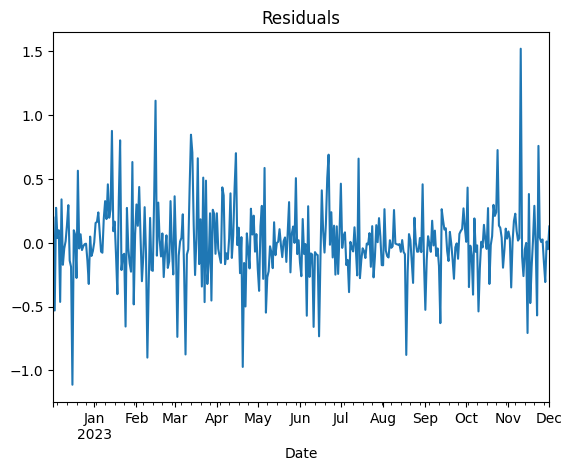

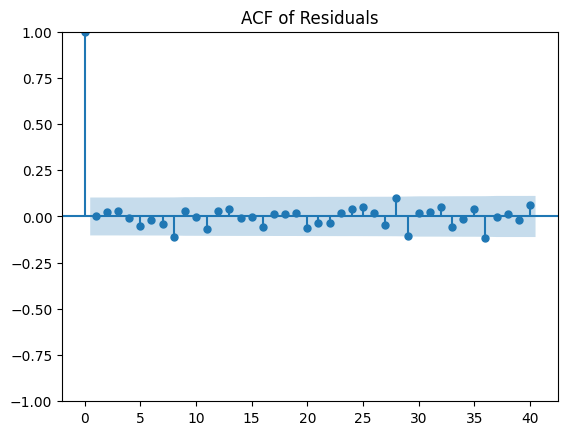

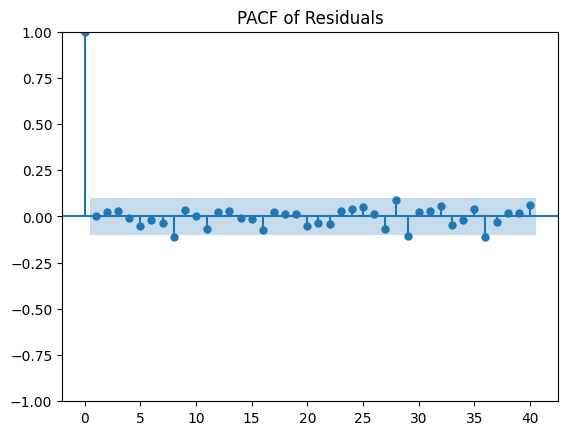

In [131]:
import statsmodels.api as sm

# Assuming df['Close_Log_Growth_Rate'] is your time series data

# Create and fit the ARMA(1,1) model
model = sm.tsa.ARIMA(df['Close_Log_Growth_Rate'], order=(1, 0, 1))
results = model.fit()

# Print the model summary
print(results.summary())

# Plot the residuals
residuals = results.resid
residuals.plot(title="Residuals")
plt.show()

# Plot the autocorrelation of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.show()

# Plot the partial autocorrelation of residuals
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.title("PACF of Residuals")
plt.show()


Looks like the first lag of AR and MA are not significant (they fall within the confidence intervals and do not have p values less than 0.05).

## Regression model with time series errors

We know that smaller coins often follow the fluctuations of Bitcoin. In other words, the price of ETH hevily depends on BTC. Given this information, we can model a regression and then add AR or MA errors to properly model the fluctuations.

Lets confirm this:

In [132]:
#!pip install yfinance
import yfinance as yf
import datetime as dt
import pandas as pd

start = dt.datetime(2022,12,1)
end = dt.datetime(2023,12,2)

df_btc = yf.download('BTC-AUD', start, end)

[*********************100%%**********************]  1 of 1 completed


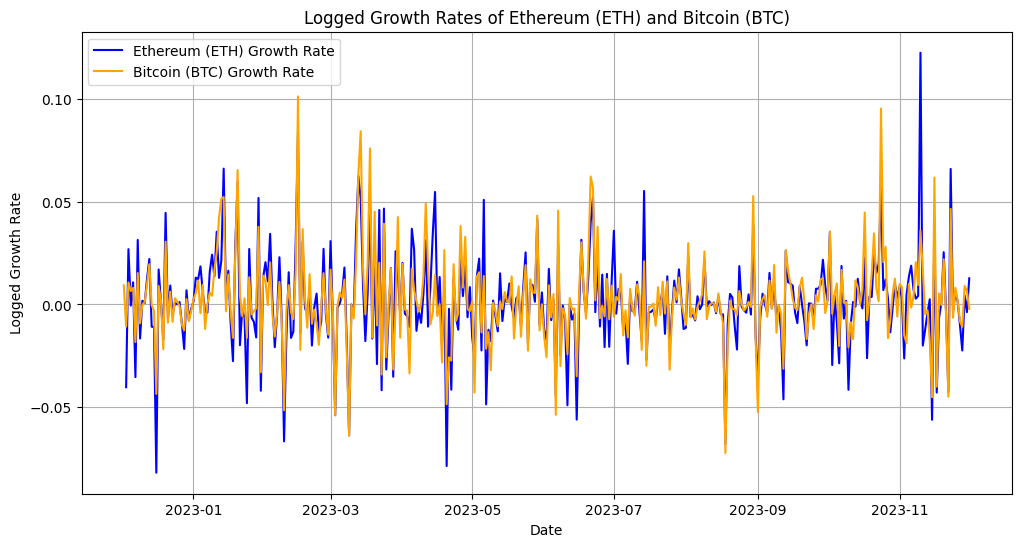

In [135]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your Ethereum (ETH) DataFrame and df_btc is your Bitcoin (BTC) DataFrame

# Calculate the logged growth rates for ETH and BTC
eth_growth_rate = np.log(df['Close'] / df['Close'].shift(1))
btc_growth_rate = np.log(df_btc['Close'] / df_btc['Close'].shift(1))

# Plot the logged growth rates
plt.figure(figsize=(12, 6))
plt.plot(df.index, eth_growth_rate, label='Ethereum (ETH) Growth Rate', color='blue')
plt.plot(df_btc.index, btc_growth_rate, label='Bitcoin (BTC) Growth Rate', color='orange')

# Set plot labels and legend
plt.xlabel('Date')
plt.ylabel('Logged Growth Rate')
plt.title('Logged Growth Rates of Ethereum (ETH) and Bitcoin (BTC)')
plt.legend()

# Show the plot
plt.grid()
plt.show()


In [138]:
import numpy as np

# Assuming eth_growth_rate and btc_growth_rate are the logged growth rates
# for Ethereum (ETH) and Bitcoin (BTC), respectively

# Ensure that both series have the same length by removing the first NaN value
eth_growth_rate = eth_growth_rate.dropna()
btc_growth_rate = btc_growth_rate.dropna()

# Calculate the mean of the Ethereum (ETH) logged growth rates
mean_eth = np.mean(eth_growth_rate)

# Calculate the total sum of squares (TSS)
tss = np.sum((eth_growth_rate - mean_eth) ** 2)

# Calculate the sum of squares of residuals (RSS)
rss = np.sum((eth_growth_rate - btc_growth_rate) ** 2)

# Calculate R-squared (coefficient of determination)
r_squared = 1 - (rss / tss)

print(f'R-squared: {r_squared:.4f}')


R-squared: 0.7023


Looks like the growth rates are overlaid on each other and the R squared is quite high. I think its safe to assume that BTC affects ETH significantly.

Lets model this by using a simple linear regression of y=X1 * B1 + e and investigating the ACF and PACF of the error term:

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     886.7
Date:                Mon, 25 Dec 2023   Prob (F-statistic):           2.30e-99
Time:                        16:40:38   Log-Likelihood:                 1074.0
No. Observations:                 364   AIC:                            -2144.
Df Residuals:                     362   BIC:                            -2136.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -1.067      0.2

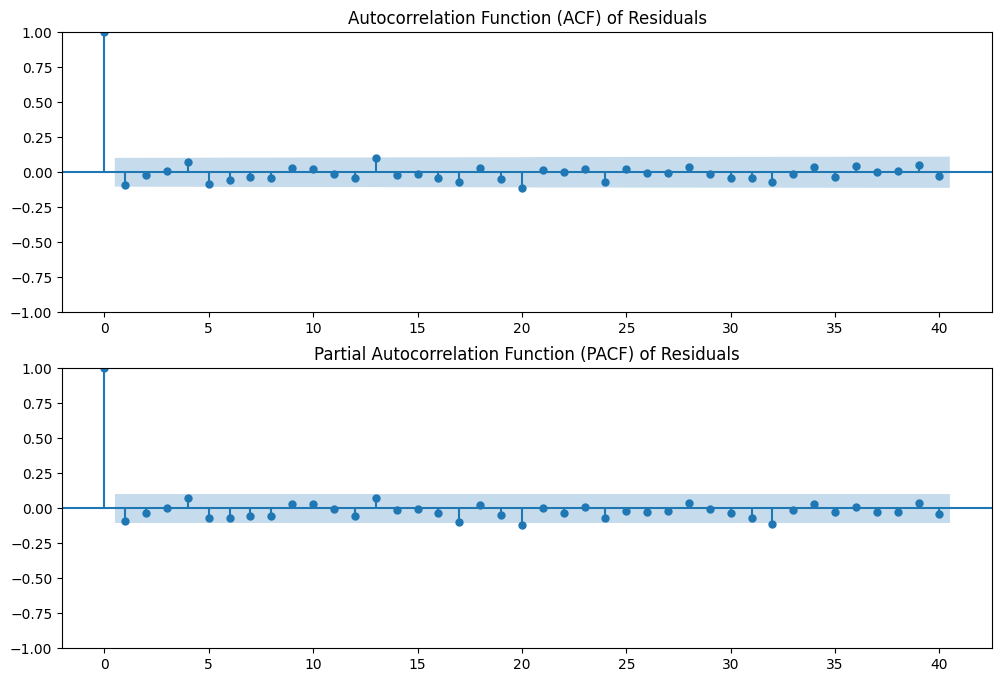

In [142]:
import statsmodels.api as sm
import pandas as pd

# Assuming eth_growth_rate and btc_growth_rate are the logged growth rates
# for Ethereum (ETH) and Bitcoin (BTC), respectively

# Ensure that both series have the same length by removing the first NaN value
eth_growth_rate = eth_growth_rate.dropna()
btc_growth_rate = btc_growth_rate.dropna()

# Align the indices of both series
eth_growth_rate.index = pd.to_datetime(eth_growth_rate.index)  # Convert index to datetime if not already
btc_growth_rate.index = pd.to_datetime(btc_growth_rate.index)  # Convert index to datetime if not already
eth_growth_rate, btc_growth_rate = eth_growth_rate.align(btc_growth_rate, join='inner')

# Fit the linear regression model using logged growth rates
X = sm.add_constant(btc_growth_rate)
model = sm.OLS(eth_growth_rate, X)
results = model.fit()

# Print the summary of the regression results
print(results.summary())

# Calculate the residuals of the regression model
residuals = results.resid

# Plot the ACF and PACF of the residuals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) of Residuals')

# PACF plot
sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF) of Residuals')

plt.show()


The BTC coefficient is significant. Therefore, for every 1% increase in BTC, there is a 91.38% increase in ETH.

Further, the ACF and PACF of the residuals show there is no autocorelation left in the lags.